In [1]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

In [2]:
CLIENT_ID = "sh-969df021-7636-4a68-bc3a-382929f49fe8"
CLIENT_SECRET = "6fPWsYwTCbFEdCh7mf3ogVeecvlhwhuX"

# set up credentials
client = BackendApplicationClient(client_id=CLIENT_ID)
oauth = OAuth2Session(client=client)

# get an authentication token
token = oauth.fetch_token(
    token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
    client_secret=CLIENT_SECRET,
    include_client_id=True
)

In [3]:
bbox = [-87.72171, 17.11848, -87.342682, 17.481674]
start_date = "2020-06-01"
end_date = "2020-08-31"
collection_id = "sentinel-2-l2a"

In [4]:
def get_image(bbox, start_date, end_date):

  # evalscript
  evalscript = """
  //VERSION=3

  function setup() {
    return {
      input: ["B04", "B03", "B02", "B08"],
      output: { id: 'default',
                bands: 4,
                sampleType: "UINT16"
                }
    };
  }

  function evaluatePixel(sample) {
    return [sample.B04 *10000, sample.B03*10000 , sample.B02*10000 , sample.B08*10000 ];
  }
  """

  # request body/payload
  json_request = {
      'input': {
          'bounds': {
              'bbox': bbox,
              'properties': {
                  'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'
              }
          },
          'data': [
              {
                  'type': 'S2L2A',
                  'dataFilter': {
                      'timeRange': {
                          'from': f'{start_date}T00:00:00Z',
                          'to': f'{end_date}T23:59:59Z'
                      },
                      'mosaickingOrder': 'leastCC',
                  },
                  'processing': {
                      'resX': 10,
                      'resY': 10
                  }
              }
          ]
      },
      'output': {

          'responses': [
              {
                  'identifier': 'default',
                  'format': {
                      'type': 'image/tiff',
                  }
              }
          ]
      },
      'evalscript': evalscript
  }

  url_request = "https://sh.dataspace.copernicus.eu/api/v1/process"
  headers_request = {
      "Authorization": f"Bearer {token['access_token']}"
  }

  # Send the request
  response = oauth.post(url_request, headers=headers_request, json=json_request)
  return response

In [5]:
def download_image(response, filename):
  if response.status_code == 200:
    with open(f"{filename}.tif", "wb") as f:
        f.write(response.content)
  else:
      print(f"Error: {response.status_code}, {response.text}")


In [6]:
test1_dates = [
    "2016-07-01",
    "2017-07-11",
    "2019-08-10",
    "2023-07-25",
    "2024-08-08",
    "2025-08-05",
]

test2_dates = [
    "2016-07-01",
    "2017-07-11",
    "2019-08-10",
    "2023-07-25",
    "2024-08-08",
    "2025-08-05",
]

test1_box = [-54.678955, -4.121806, -54.481201, -3.940981] # test 2
lat, lon = -3.20,-54.21375 #test 3
delta = 0.023

#test2_box = [lon-delta, lat-delta, lon+delta, lat+delta]

selected_date = test1_dates
selected_box = test1_box


In [7]:
for i in range(len(selected_date)):
  date = selected_date[i]
  year = date.split("-")[0]
  response = get_image(selected_box, date, date)
  download_image(response, f"{year}_test_{i+1}")



In [8]:
! rm -rf check/
! mkdir check
! mv *.tif check/

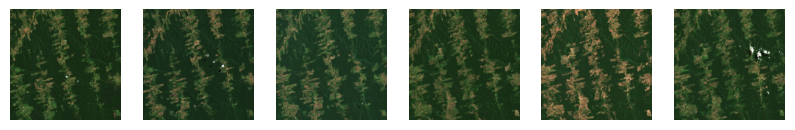

In [9]:
fig,ax = plt.subplots(1,len(selected_date),figsize=(10,10))
for i in range(len(selected_date)):
  year = selected_date[i].split("-")[0]
  filename = f"check/{year}_test_{i+1}"
  image_data = tiff.imread(f"{filename}.tif")
  rgb = np.clip(image_data[:,:,0:3] / 2000 , 0, 1)
  ax[i].imshow(rgb)
  ax[i].axis('off')
plt.show()

TIME COMPARATION

Compare downloaded pictures with a model and generate informative graphs

In [ ]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
import rasterio
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import segmentation_models_pytorch as smp

In [ ]:
## TIME COMPARATION FOR PAN (j)
root_dir = 'check/'
class AmazonInferenceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Apuntamos directamente a la carpeta de imágenes
        self.image_dir = root_dir
        self.images = sorted(os.listdir(self.image_dir))
        self.transform = transform

        print(f"Total de imágenes para predecir: {len(self.images)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.image_dir, img_name)

        with rasterio.open(img_path) as src:
            image = src.read()
            # Mantén la misma escala que usaste en el entrenamiento
            image = (image / 10000 * 255).astype(np.uint8)

        if self.transform:
            # (4, H, W) -> (H, W, 4) para que PIL lo entienda
            image = np.moveaxis(image, 0, -1)
            image = self.transform(Image.fromarray(image))

        return image, img_name # Devolvemos el nombre para saber cuál es cuál

mean = torch.tensor([0.485, 0.456, 0.406, 0.5])
std  = torch.tensor([0.229, 0.224, 0.225, 0.5])
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

data = AmazonInferenceDataset(root_dir=root_dir, transform=preprocess)
loader = DataLoader(data, batch_size=1, shuffle=False)

Total de imágenes para predecir: 6


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = smp.PAN(
encoder_name = 'resnet101',
encoder_weights = None,
in_channels = 4,
classes = 1,
activation='sigmoid'
).to(device)

state_dict = torch.load('forest_model_final.pth', map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

cuda


PAN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [ ]:
results = {}

with torch.no_grad():
    for image, img_name in loader:
        image = image.to(device)

        # El modelo devuelve probabilidades (gracias a activation='sigmoid')
        output = model(image)

        # Umbral para binarizar: 1 si > 0.5 (bosque), 0 si no
        mask_pred = (output > 0.5).float()

        # Limpieza para visualización/guardado
        mask_np = mask_pred.cpu().squeeze().numpy()
        results[img_name[0]] = mask_np

print(f"Predicciones terminadas para {len(results)} archivos.")

Predicciones terminadas para 6 archivos.


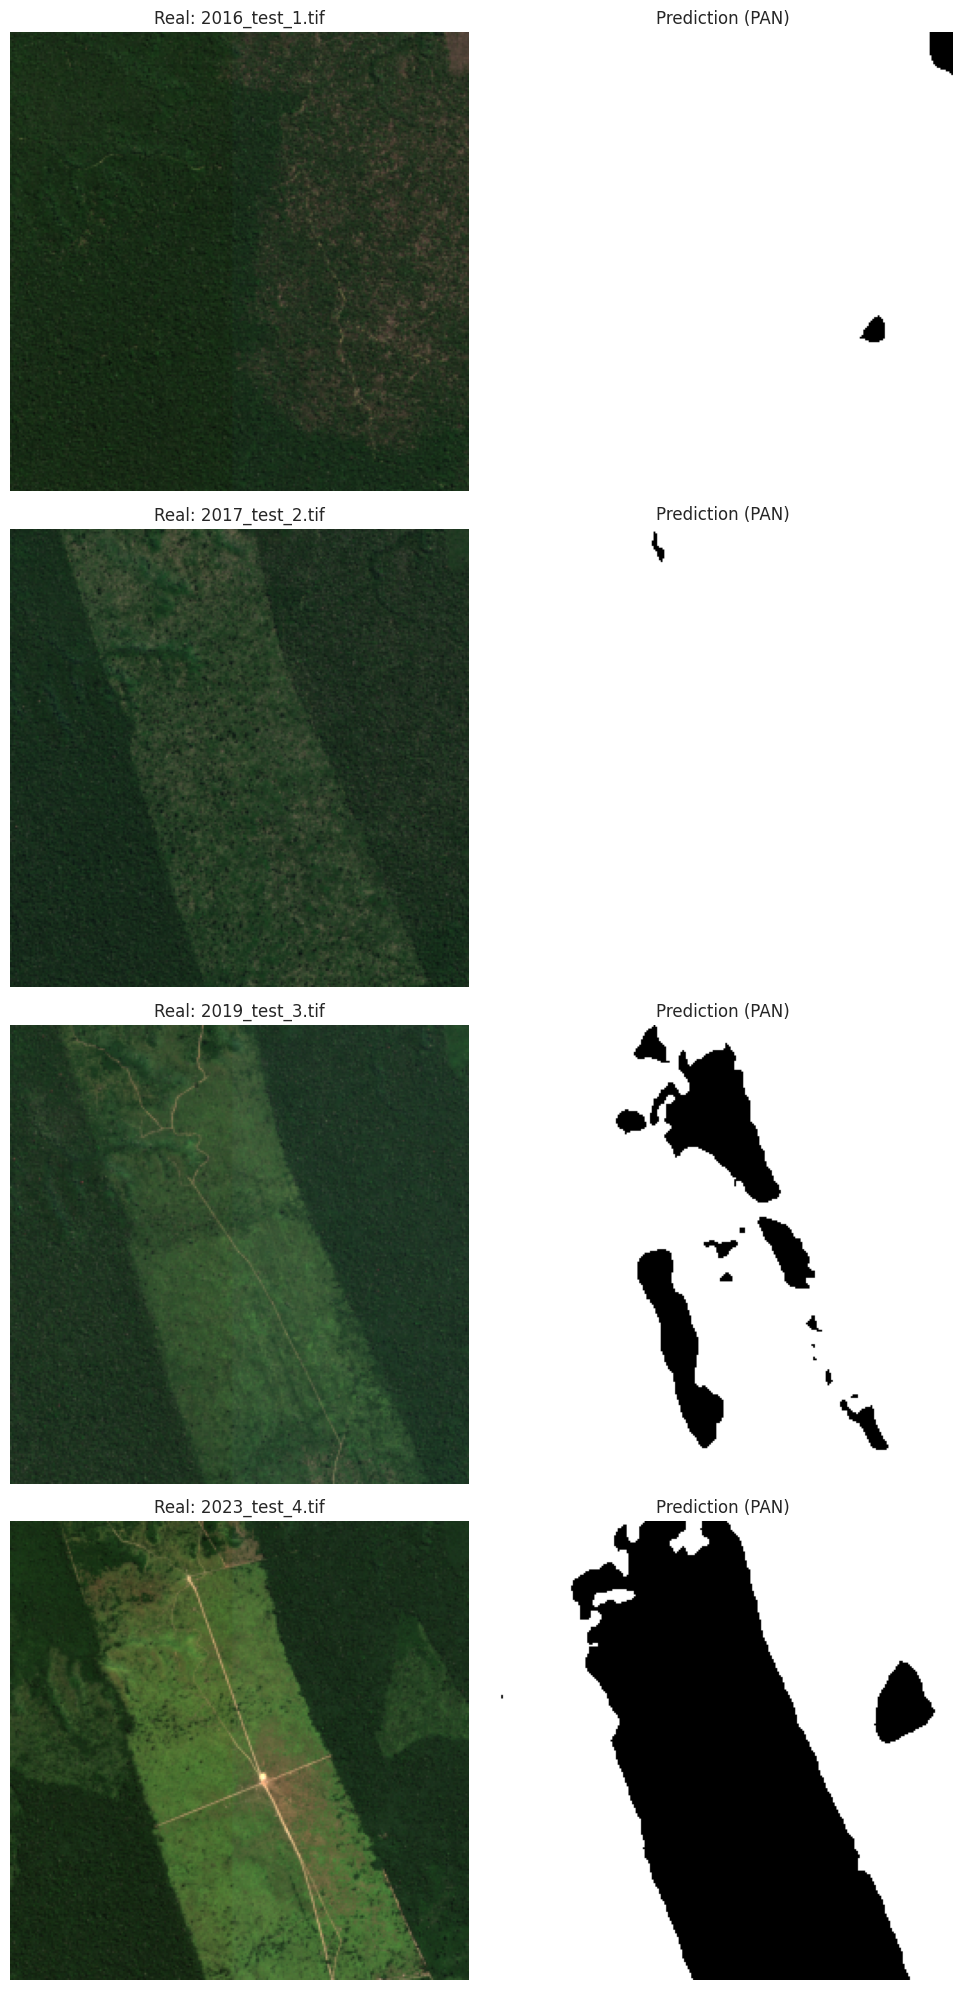

In [ ]:
import matplotlib.pyplot as plt
import os
import rasterio

# Elegimos cuántas imágenes mostrar (ej. las primeras 4)
n_images = min(4, len(results))
fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))

for i, (img_name, mask_pred) in enumerate(list(results.items())[:n_images]):
    # 1. Cargar imagen original para visualizar (solo canales RGB)
    img_path = os.path.join(root_dir, img_name)
    with rasterio.open(img_path) as src:
        img_raw = src.read([1, 2, 3])
        img_viz = np.moveaxis(img_raw, 0, -1)
        img_viz = (img_viz/2000).clip(0, 1)

    # 2. Dibujar Imagen Original
    axes[i, 0].imshow(img_viz)
    axes[i, 0].set_title(f"Real: {img_name}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask_pred, cmap='gray')
    axes[i, 1].set_title(f"Prediction (PAN)")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

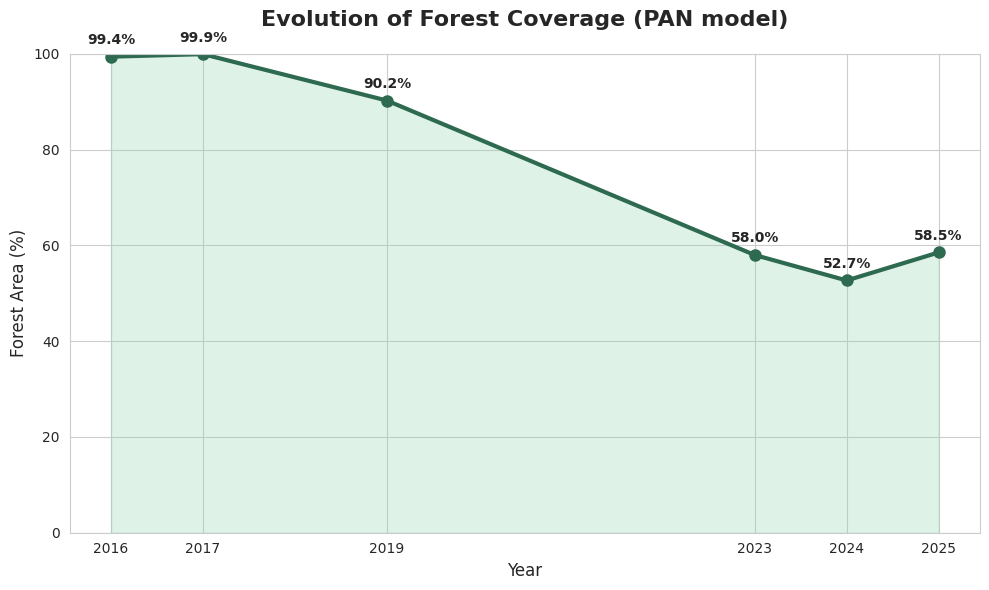

In [ ]:
import pandas as pd
import seaborn as sns

# 1. Extraer datos de los resultados
stats = []
for img_name, mask_pred in results.items():
    # Asumimos que el nombre empieza por el año (ej: "2016_...")
    year = int(img_name.split('_')[0])

    # Calcular porcentaje de bosque (píxeles con valor 1)
    forest_pixels = np.sum(mask_pred == 1)
    total_pixels = mask_pred.size
    percentage = (forest_pixels / total_pixels) * 100

    stats.append({'Year': year, 'Forest_Percentage': percentage})

# 2. Crear un DataFrame y agrupar por año (promediando los 'spots' TL, TR, etc.)
df = pd.DataFrame(stats)
df_yearly = df.groupby('Year')['Forest_Percentage'].mean().reset_index()

# 3. Graficar
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Dibujar la línea y los puntos
plt.plot(df_yearly['Year'], df_yearly['Forest_Percentage'],
         marker='o', linestyle='-', color='#2d6a4f', linewidth=3, markersize=8)

# Rellenar el área debajo de la línea para un look más moderno
plt.fill_between(df_yearly['Year'], df_yearly['Forest_Percentage'], color='#95d5b2', alpha=0.3)

# Configurar textos
plt.title('Evolution of Forest Coverage (PAN model)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Forest Area (%)', fontsize=12)
plt.xticks(df_yearly['Year'])
plt.ylim(0, 100)

for x, y in zip(df_yearly['Year'], df_yearly['Forest_Percentage']):
    plt.text(x, y + 2, f'{y:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()